In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

In [136]:
import stan_utility

In [137]:
import stan

# Bayesian Inference

### fake data

In [101]:
from faker import Faker # library for generating random num

In [102]:
faker = Faker()
Faker.seed(1000)

In [103]:
# Generate fake data
data_simu = {
    'Pregnancies': [faker.random_int(min=0, max=17) for _ in range(3000)],
    'Glucose': [faker.random_int(min=0, max=200) for _ in range(3000)],
    'BloodPressure': [faker.random_int(min=0, max=100) for _ in range(3000)],
    'SkinTickness': [faker.random_int(min=0, max=100) for _ in range(3000)],
    'Insulin': [faker.random_int() for _ in range(3000)],
    'BMI': [faker.random.uniform(a=0, b=67) for _ in range(3000)],
    'DiabetesPedigreeFunction': [faker.random.uniform(a=0, b=3) for _ in range(3000)],
    'Age': [faker.random_int(min=1, max=100) for _ in range(3000)],
    'Outcome': [faker.random_int(min=0, max=1) for _ in range(3000)]
}


# Create a DataFrame
df_simu = pd.DataFrame(data_simu)

# Display the DataFrame
df_simu.head()

,Pregnancies,Glucose,BloodPressure,SkinTickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,13,59,24,99,6861,40.375093,1.122980,90,1
1,3,198,62,54,7416,60.019936,1.164683,84,1
2,12,89,42,80,7606,29.901838,0.776493,50,0
3,11,169,66,73,9796,18.782294,2.959806,82,1
4,2,24,60,76,247,13.799934,1.003071,90,0


In [104]:
df_simu.describe()

,Pregnancies,Glucose,BloodPressure,SkinTickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,8.546000,101.152667,50.608333,49.796667,4960.285333,33.350612,1.487909,50.666667,0.497333
std,5.159078,58.629718,29.006288,29.239134,2856.292654,19.085782,0.867345,29.201538,0.500076
min,0.000000,0.000000,0.000000,0.000000,2.000000,0.013702,0.000393,1.000000,0.000000
25%,4.000000,51.000000,26.000000,25.000000,2485.250000,16.784712,0.733832,25.000000,0.000000
50%,8.000000,102.000000,51.000000,50.000000,4942.500000,33.096036,1.477582,50.000000,0.000000
75%,13.000000,153.000000,75.000000,75.000000,7436.250000,49.275035,2.233451,77.000000,1.000000
max,17.000000,200.000000,100.000000,100.000000,9994.000000,66.993839,2.999799,100.000000,1.000000


/var/folders/37/wj6jtm190bz4csmcwzcscp440000gn/T/ipykernel_1403/2277086940.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_simu.DiabetesPedigreeFunction,color='r')


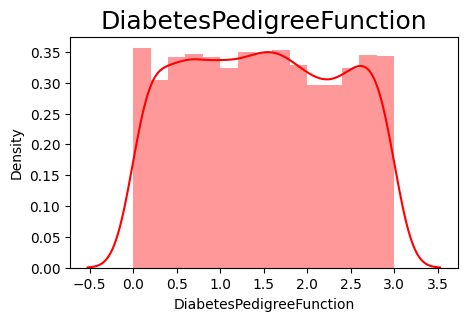

In [105]:
plt.figure(figsize=(5,3))
sns.distplot(df_simu.DiabetesPedigreeFunction,color='r')
plt.title('DiabetesPedigreeFunction',size=18)
# plt.xlabel('Charges',size=14)
# plt.ylabel('Density',size=14)
plt.show()

<Axes: xlabel='Glucose', ylabel='DiabetesPedigreeFunction'>

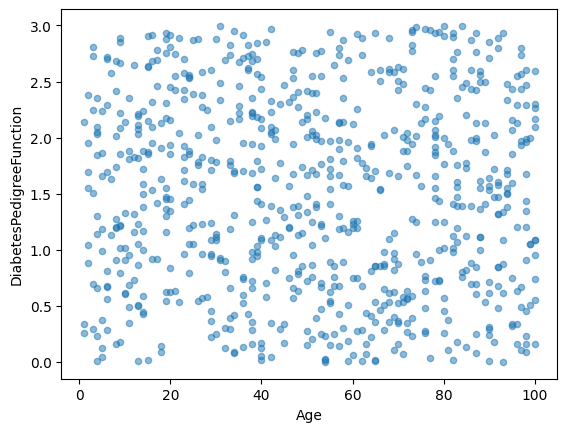

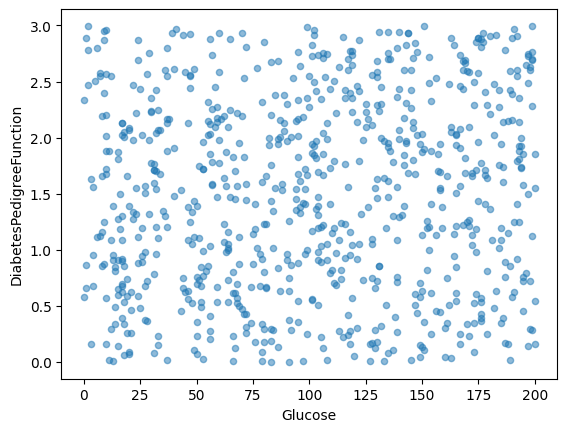

In [14]:
# print(df.loc[:, 'Outcome'].values)
df_simu.sort_values(by='Age').reset_index(drop=True).plot.scatter(x='Age', y="DiabetesPedigreeFunction", alpha=0.5)
df_simu.sort_values(by='Glucose').reset_index(drop=True).plot.scatter(x='Glucose', y="DiabetesPedigreeFunction", alpha=0.5)

## 1. Bayseian modeling

In [138]:
import nest_asyncio #this library is important to use pystan

nest_asyncio.apply()

In [139]:
import pandas as pd
import csv

In [140]:
import scipy.stats as stats

In [141]:
## import data

df = pd.read_csv('./db/diabetes.csv')

### purpose of analysis
The goal of this analysis is to understand how liklihood of diabetes happened with the age of pregnancies.\
In order to understand it, we will use a bayesian linear regression model.


#### 1. EDA
In order to set initial assumption as prior distribution, we conducted EDA to plot distribution of age and diabetes (DiabetesPedigreeFunction).

source: https://sakurachaojun.github.io/PSYO3505/data/EDA.html

In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [143]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [144]:
# df["age_over35"] = (df['Age'] > 35).astype(int)

In [145]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [146]:
# plt.figure(figsize=(5,3))
# sns.distplot(df.BloodPressure,color='r')
# plt.title('BloodPressure',size=18)
# # plt.xlabel('Charges',size=14)
# # plt.ylabel('Density',size=14)
# plt.show()

In [147]:
# # print(df.loc[:, 'Outcome'].values)
# df.sort_values(by='Pregnancies').reset_index(drop=True).plot.scatter(x='Pregnancies', y="BloodPressure", alpha=0.5)

#### Explain the model
1. Data variables
2. Likelihood function and parameters
3. Prior distribution
4. Formal specification
5. Prior predictive check

## 2. Details of the computation



In [148]:
stan_code = """
data {
    // num of observation
    int<lower=0> N;
    // num of success
     vector[N] blood;
     vector[N] diabetes;
}

parameters {
    //prob of success
    real alpha;
    real beta;
    real<lower=0> sigma;
}

model {
    //prior
    alpha ~ normal(0, 5);
    beta ~ normal(0, 5);
    
    sigma ~ cauchy(0, 5);
    blood ~ normal(alpha + beta * diabetes, sigma); //likelihood
}

generated quantities {
    vector[N] log_lik;
    vector[N] blood_pred;

    //log-likelihood
    for (n in 1:N){
     log_lik[n] = normal_lpdf(blood[n] | alpha + beta * diabetes[n], sigma);
    }
    //predictive 
     for (n in 1:N) {
        blood_pred[n] = normal_rng(alpha + beta * diabetes[n], sigma);
    }
}

"""


### 2-1. Specify data

In [149]:
data = {
"N": len(df), 
"blood": df.loc[:, "BloodPressure"].values,
"diabetes": df.loc[:, "DiabetesPedigreeFunction"].values,
}

### 2-2. Build model

In [150]:
stan_model = stan.build(stan_code, data=data)

Building: 0.2s
Building: 0.3s
Building: 0.4s
Building: 0.6s
Building: 0.7s
Building: 0.8s
Building: 0.9s
Building: 1.0s
Building: 1.1s
Building: 1.2s
Building: 1.3s
Building: 1.4s
Building: 1.5s
Building: 1.6s
Building: 1.7s
Building: 1.8s
Building: 1.9s
Building: 2.0s
Building: 2.1s
Building: 2.2s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/airfqefx/model_airfqefx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:8:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/chainable_object.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/core/typedefs.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-pac

Building: 2.3s
Building: 2.4s
Building: 2.5s
Building: 2.6s
Building: 2.7s
Building: 2.8s
Building: 2.9s
Building: 3.0s
Building: 3.1s
Building: 3.2s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/airfqefx/model_airfqefx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:26:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/beta.hpp:70:32: warning: lambda capture 'b' is not used [-Wunused-lambda-capture]
                           [a, b, digamma_ab](auto& vi) mutable {
                             ~~^


Building: 3.3s
Building: 3.4s
Building: 3.5s
Building: 3.6s
Building: 3.7s
Building: 3.8s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/airfqefx/model_airfqefx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 4.0s
Building: 4.1s
Building: 4.2s
Building: 4.3s
Building: 4.4s
Building: 4.5s
Building: 4.6s
Building: 4.7s
Building: 4.8s
Building: 4.9s
Building: 5.0s
Building: 5.1s
Building: 5.2s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/airfqefx/model_airfqefx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:12:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/hcubature.hpp:468:7: warning: unused variable 'kdiv' [-Wunused-variable]
  int kdiv = kdivide;
      ^


Building: 5.3s
Building: 5.4s
Building: 5.5s
Building: 5.6s
Building: 5.7s
Building: 5.8s
Building: 5.9s
Building: 6.0s
Building: 6.1s
Building: 6.2s
Building: 6.3s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/airfqefx/model_airfqefx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:198:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor.hpp:15:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/functor/integrate_ode_rk45.hpp:6:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-

Building: 6.4s
Building: 6.5s
Building: 6.6s
Building: 6.7s
Building: 6.8s
Building: 6.9s
Building: 7.0s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/airfqefx/model_airfqefx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:128:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/gaussian_dlm_obs_rng.hpp:98:7: warning: unused variable 'n' [-Wunused-variable]
  int n = G.rows();  // number of states
      ^


Building: 7.1s
Building: 7.2s
Building: 7.3s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/airfqefx/model_airfqefx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:210:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/multi_student_t_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan

Building: 7.5s
Building: 7.6s
Building: 7.7s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/airfqefx/model_airfqefx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:14:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim.hpp:16:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob.hpp:312:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/prob/skew_double_exponential_ccdf_log.hpp:5:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan

Building: 7.8s
Building: 7.9s


/Users/eunkang/Library/Caches/httpstan/4.10.1/models/airfqefx/model_airfqefx.cpp:277:11: warning: variable 'pos__' set but not used [-Wunused-but-set-variable]
      int pos__ = std::numeric_limits<int>::min();
          ^
/Users/eunkang/Library/Caches/httpstan/4.10.1/models/airfqefx/model_airfqefx.cpp:315:11: warning: variable 'pos__' set but not used [-Wunused-but-set-variable]
      int pos__ = std::numeric_limits<int>::min();
          ^


Building: 8.0s
Building: 8.1s
Building: 8.2s
Building: 8.3s
Building: 8.4s
Building: 8.5s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/airfqefx/model_airfqefx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:55:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/

Building: 8.6s
Building: 8.7s
Building: 8.8s
Building: 8.9s
Building: 9.0s


/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:192:12: warning: unused variable 'pre_mult' [-Wunused-variable]
      auto pre_mult = a2 * pow(1 - z, -1 - a2);
           ^
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:307:20: note: in instantiation of function template specialization 'stan::math::internal::grad_2F1_impl<true, true, true, true, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, std::tuple<stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>, stan::math::var_value<double>>>' requested here
  return internal::grad_2F1_impl<true, true, true, true>(a1, a2, b1, z,
                   ^
In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/airfqefx/model_airfqefx.cpp:2:
In file i

Building: 9.1s
Building: 9.2s
Building: 9.3s
Building: 9.4s
Building: 9.5s
Building: 9.6s
Building: 9.7s
Building: 9.8s
Building: 9.9s
Building: 10.0s


In file included from /Users/eunkang/Library/Caches/httpstan/4.10.1/models/airfqefx/model_airfqefx.cpp:2:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/model/model_header.hpp:4:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math.hpp:19:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev.hpp:10:
In file included from /Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun.hpp:100:
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/include/stan/math/rev/fun/lb_constrain.hpp:114:33: warning: lambda capture 'lp' is not used [-Wunused-lambda-capture]
                               [lp, arena_lb = var(lb)](auto& vi) mutable {
                                ^
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/h

Building: 10.1s
Building: 10.2s
Building: 10.3s
Building: 10.4s
Building: 10.5s
Building: 10.6s
Building: 10.7s
Building: 10.9s
Building: 11.0s
Building: 11.1s
Building: 11.2s
Building: 11.3s
Building: 11.4s
Building: 11.5s
Building: 11.6s
Building: 11.7s
Building: 11.8s
Building: 11.9s
Building: 12.0s
Building: 12.1s
Building: 12.2s
Building: 12.3s
Building: 12.4s
Building: 12.5s
Building: 12.6s
Building: 12.7s
Building: 12.8s
Building: 12.9s
Building: 13.0s
Building: 13.1s
Building: 13.2s
Building: 13.3s
Building: 13.4s
Building: 13.5s
Building: 13.6s
Building: 13.7s


21 warnings generated.
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/stan_services.o) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc_proxy.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbbmalloc.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: dylib (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libtbb.dylib) was built for newer macOS version (10.11) than being linked (10.9)
ld: warning: object file (/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/lib/libsundials_nvecserial.a(nvector_serial.o)) was built for newer macOS version (11.0) than being linked (10.9)
ld: warning: ob

### 2-3 Fit the model

- quantify with Hamiltonian Monte Carlo


In [152]:
fit = stan_model.sample(num_chains=4, num_samples=500) ## posterior: Stan generates samples from the joint posterior distribution of the parameters

Sampling:   0%
Future exception was never retrieved
future: <Future finished exception=RuntimeError('write: Broken pipe [system:32]')>
concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/concurrent/futures/process.py", line 246, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/services_stub.py", line 47, in _make_lazy_function_wrapper_helper
    return function(*args, **kwargs)  # type: ignore
RuntimeError: write: Broken pipe [system:32]
"""

The above exception was the direct cause of the following exception:

RuntimeError: write: Broken pipe [system:32]
Sampling:   3% (200/6000)
Sampling:  12% (700/6000)
Sampling:  37% (2200/6000)
Sampling:  62% (3700/6000)
Sampling:  83% (5000/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  G

## 3. Validate a fit. Diagnostics

In [153]:
stan_data_simu = az.from_pystan(
    posterior=fit,
    posterior_predictive="blood_pred",
    log_likelihood={
        "blood": "log_lik",
    },
    observed_data=["blood"],
    posterior_model=stan_model,
    coords={"blood": np.arange(data["N"])},
)

In [154]:
stan_data_simu

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

<Axes: xlabel='blood / blood_pred'>

/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


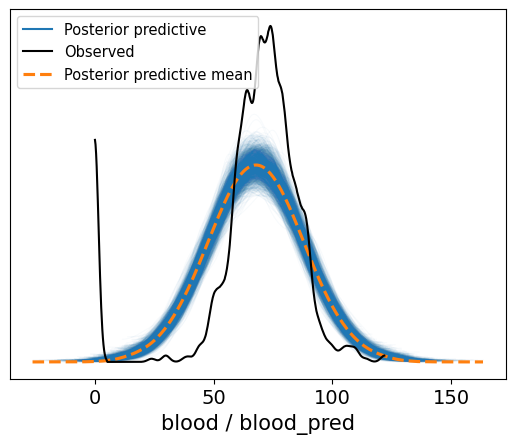

Future exception was never retrieved
future: <Future finished exception=RuntimeError('write: Broken pipe [system:32]')>
concurrent.futures.process._RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/concurrent/futures/process.py", line 246, in _process_worker
    r = call_item.fn(*call_item.args, **call_item.kwargs)
  File "/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/httpstan/services_stub.py", line 47, in _make_lazy_function_wrapper_helper
    return function(*args, **kwargs)  # type: ignore
RuntimeError: write: Broken pipe [system:32]
"""

The above exception was the direct cause of the following exception:

RuntimeError: write: Broken pipe [system:32]


In [155]:
az.plot_ppc(stan_data_simu, data_pairs={"blood": "blood_pred"}, alpha=0.03, textsize=14)

The visualization shows that the simulated data sets (diabetes_rep) are different from observed log.

In [156]:
## diagnostic test with treedepth 

def check_treedepth(summary, max_treedepth = 10, quiet=False):
    """Check transitions that ended prematurely due to maximum tree depth limit"""
    # sampler_params = fit.get_sampler_params(inc_warmup=False)
    sampler_params = summary.sample_stats['tree_depth'].values
    depths = [x for y in sampler_params for x in y]
    n = sum(1 for x in depths if x == max_treedepth)
    N = len(depths)

    if not quiet:
        print(('{} of {} iterations saturated the maximum tree depth of {}'
              + ' ({}%)').format(n, N, max_treedepth, 100 * n / N))
    if n > 0:
        if not quiet:
            print('  Run again with max_treedepth set to a larger value to avoid saturation')
        else:
            return False
    else:
        if quiet:
            return True

In [50]:
# def check_rhat(summary):
#     """Checks the potential scale reduction factors"""
#     from math import isnan
#     from math import isinf

#     fit_summary = fit.summary(probs=[0.5])
#     rhats = [x[5] for x in fit_summary['summary']]
#     names = fit_summary['summary_rownames']

#     no_warning = True
#     for rhat, name in zip(rhats, names):
#         if (rhat > 1.1 or isnan(rhat) or isinf(rhat)):
#             print('Rhat for parameter {} is {}!'.format(name, rhat))
#             no_warning = False
#     if no_warning:
#         print('Rhat looks reasonable for all parameters')
#     else:
#         print('  Rhat above 1.1 indicates that the chains very likely have not mixed')


In [157]:
## diagnostic test with divergence

def check_div(summary, quiet=False):
    """Check transitions that ended with a divergence"""
    sampler_params = summary.sample_stats['diverging'].values
    divergent = [x for y in sampler_params for x in y]
    # n = sum(divergent)
    divergent = [True if element == "True" else False for element in divergent]
    n = divergent.count(True)
    N = len(divergent)
    if not quiet:
        print('{} of {} iterations ended with a divergence ({}%)'.format(n, N,
            100 * n / N))

    if n > 0:
        if not quiet:
            print('  Try running with larger adapt_delta to remove the divergences')
        else:
            return False
    else:
        if quiet:
            return True

In [158]:
output = fit.to_frame()

In [159]:
output

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,alpha,beta,sigma,...,blood_pred.759,blood_pred.760,blood_pred.761,blood_pred.762,blood_pred.763,blood_pred.764,blood_pred.765,blood_pred.766,blood_pred.767,blood_pred.768
draws,,,,,,,,,,,,,,,,,,,,,
0,-2747.023507,0.997143,0.460752,2.0,3.0,0.0,2748.130511,65.748048,5.603612,19.495443,...,79.528641,127.961531,73.746589,60.234648,71.243624,68.923025,113.651988,44.093796,49.799573,70.107762
1,-2749.632616,0.831762,0.512307,3.0,7.0,0.0,2751.909515,66.159965,5.012988,20.438471,...,66.657570,61.971545,90.061382,111.162631,58.949967,50.217101,14.474786,56.136655,61.372613,75.285496
2,-2748.619490,0.867336,0.389588,3.0,7.0,0.0,2750.934863,66.532654,4.823165,19.908254,...,107.292016,106.987487,106.351047,78.210758,58.911067,78.028517,46.914304,91.937272,82.254550,57.063732
3,-2746.507563,0.996447,0.408695,4.0,15.0,0.0,2748.049122,64.809226,6.462148,19.404645,...,85.869686,96.181378,89.845316,96.130113,77.834955,93.609166,83.192529,73.355861,62.136607,75.773275
4,-2747.278419,0.915106,0.460752,4.0,15.0,0.0,2747.933271,63.847390,6.628587,19.579146,...,75.228722,114.325913,92.615961,69.997679,83.338712,78.277384,48.011233,61.057886,91.530682,76.691342
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-2747.201914,1.000000,0.408695,2.0,3.0,0.0,2750.663241,65.071820,5.036774,19.104903,...,69.110856,83.537069,50.839891,78.883364,68.141239,86.523486,32.869283,63.082524,63.915901,60.420207
1996,-2746.798821,0.913153,0.460752,2.0,7.0,0.0,2747.695586,64.846770,6.117962,19.755138,...,78.420503,42.996501,76.829367,66.571611,63.981321,58.134858,46.254655,65.365487,63.355805,78.028530
1997,-2748.907388,0.688645,0.512307,2.0,7.0,0.0,2750.835450,65.856730,7.329068,19.603151,...,92.155841,61.846069,74.021947,74.210026,95.889808,114.678789,69.462672,63.924504,67.340297,73.415497


In [160]:
summary = az.summary(fit) #https://python.arviz.org/en/stable/getting_started/Introduction.html

In [161]:
summary
## mcse_mean : Markov Chain Standard Error statistic
## ess_bulk : effective sample size  


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,64.625,1.145,62.468,66.685,0.040,0.028,813.0,1044.0,1.01
beta,6.785,1.947,3.040,10.216,0.066,0.047,860.0,1063.0,1.01
sigma,19.454,0.495,18.562,20.456,0.014,0.010,1259.0,938.0,1.00
blood_pred[0],69.081,19.393,34.411,107.247,0.460,0.325,1772.0,1833.0,1.00
blood_pred[1],65.815,19.185,29.598,102.196,0.419,0.298,2092.0,1883.0,1.00
...,...,...,...,...,...,...,...,...,...
blood_pred[763],64.942,19.186,29.961,102.068,0.433,0.306,1966.0,2147.0,1.00
blood_pred[764],67.175,19.260,31.774,103.876,0.425,0.302,2054.0,1930.0,1.00
blood_pred[765],66.235,19.999,28.117,102.916,0.445,0.315,2019.0,1899.0,1.00
blood_pred[766],66.738,19.689,31.758,105.194,0.434,0.308,2060.0,2101.0,1.00


In [78]:
check_treedepth(stan_data_simu)

0 of 1600 iterations saturated the maximum tree depth of 10 (0.0%)


In [162]:
check_div(stan_data_simu)

0 of 2000 iterations ended with a divergence (0.0%)


In [163]:
filtered_df = summary[summary['r_hat'] > 1.0]

In [164]:
filtered_df

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,64.625,1.145,62.468,66.685,0.040,0.028,813.0,1044.0,1.01
beta,6.785,1.947,3.040,10.216,0.066,0.047,860.0,1063.0,1.01


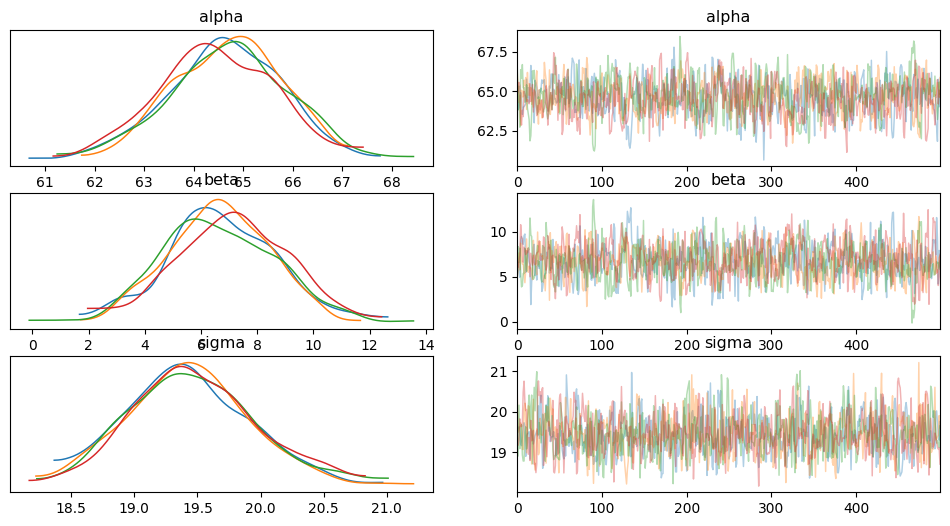

In [165]:
az.plot_trace(stan_data_simu, compact=False);

/Users/eunkang/opt/anaconda3/envs/stan/lib/python3.9/site-packages/arviz/plots/plot_utils.py:271: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (771) in plot_posterior, generating only 40 plots
  warnings.warn(


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'blood_pred\n0'}>],
       [<Axes: title={'center': 'blood_pred\n1'}>,
        <Axes: title={'center': 'blood_pred\n2'}>,
        <Axes: title={'center': 'blood_pred\n3'}>,
        <Axes: title={'center': 'blood_pred\n4'}>],
       [<Axes: title={'center': 'blood_pred\n5'}>,
        <Axes: title={'center': 'blood_pred\n6'}>,
        <Axes: title={'center': 'blood_pred\n7'}>,
        <Axes: title={'center': 'blood_pred\n8'}>],
       [<Axes: title={'center': 'blood_pred\n9'}>,
        <Axes: title={'center': 'blood_pred\n10'}>,
        <Axes: title={'center': 'blood_pred\n11'}>,
        <Axes: title={'center': 'blood_pred\n12'}>],
       [<Axes: title={'center': 'blood_pred\n13'}>,
        <Axes: title={'center': 'blood_pred\n14'}>,
        <Axes: title={'center': 'blood_pred\n15'}>,
        <Axes: title={'center': 'blood_pred\n1

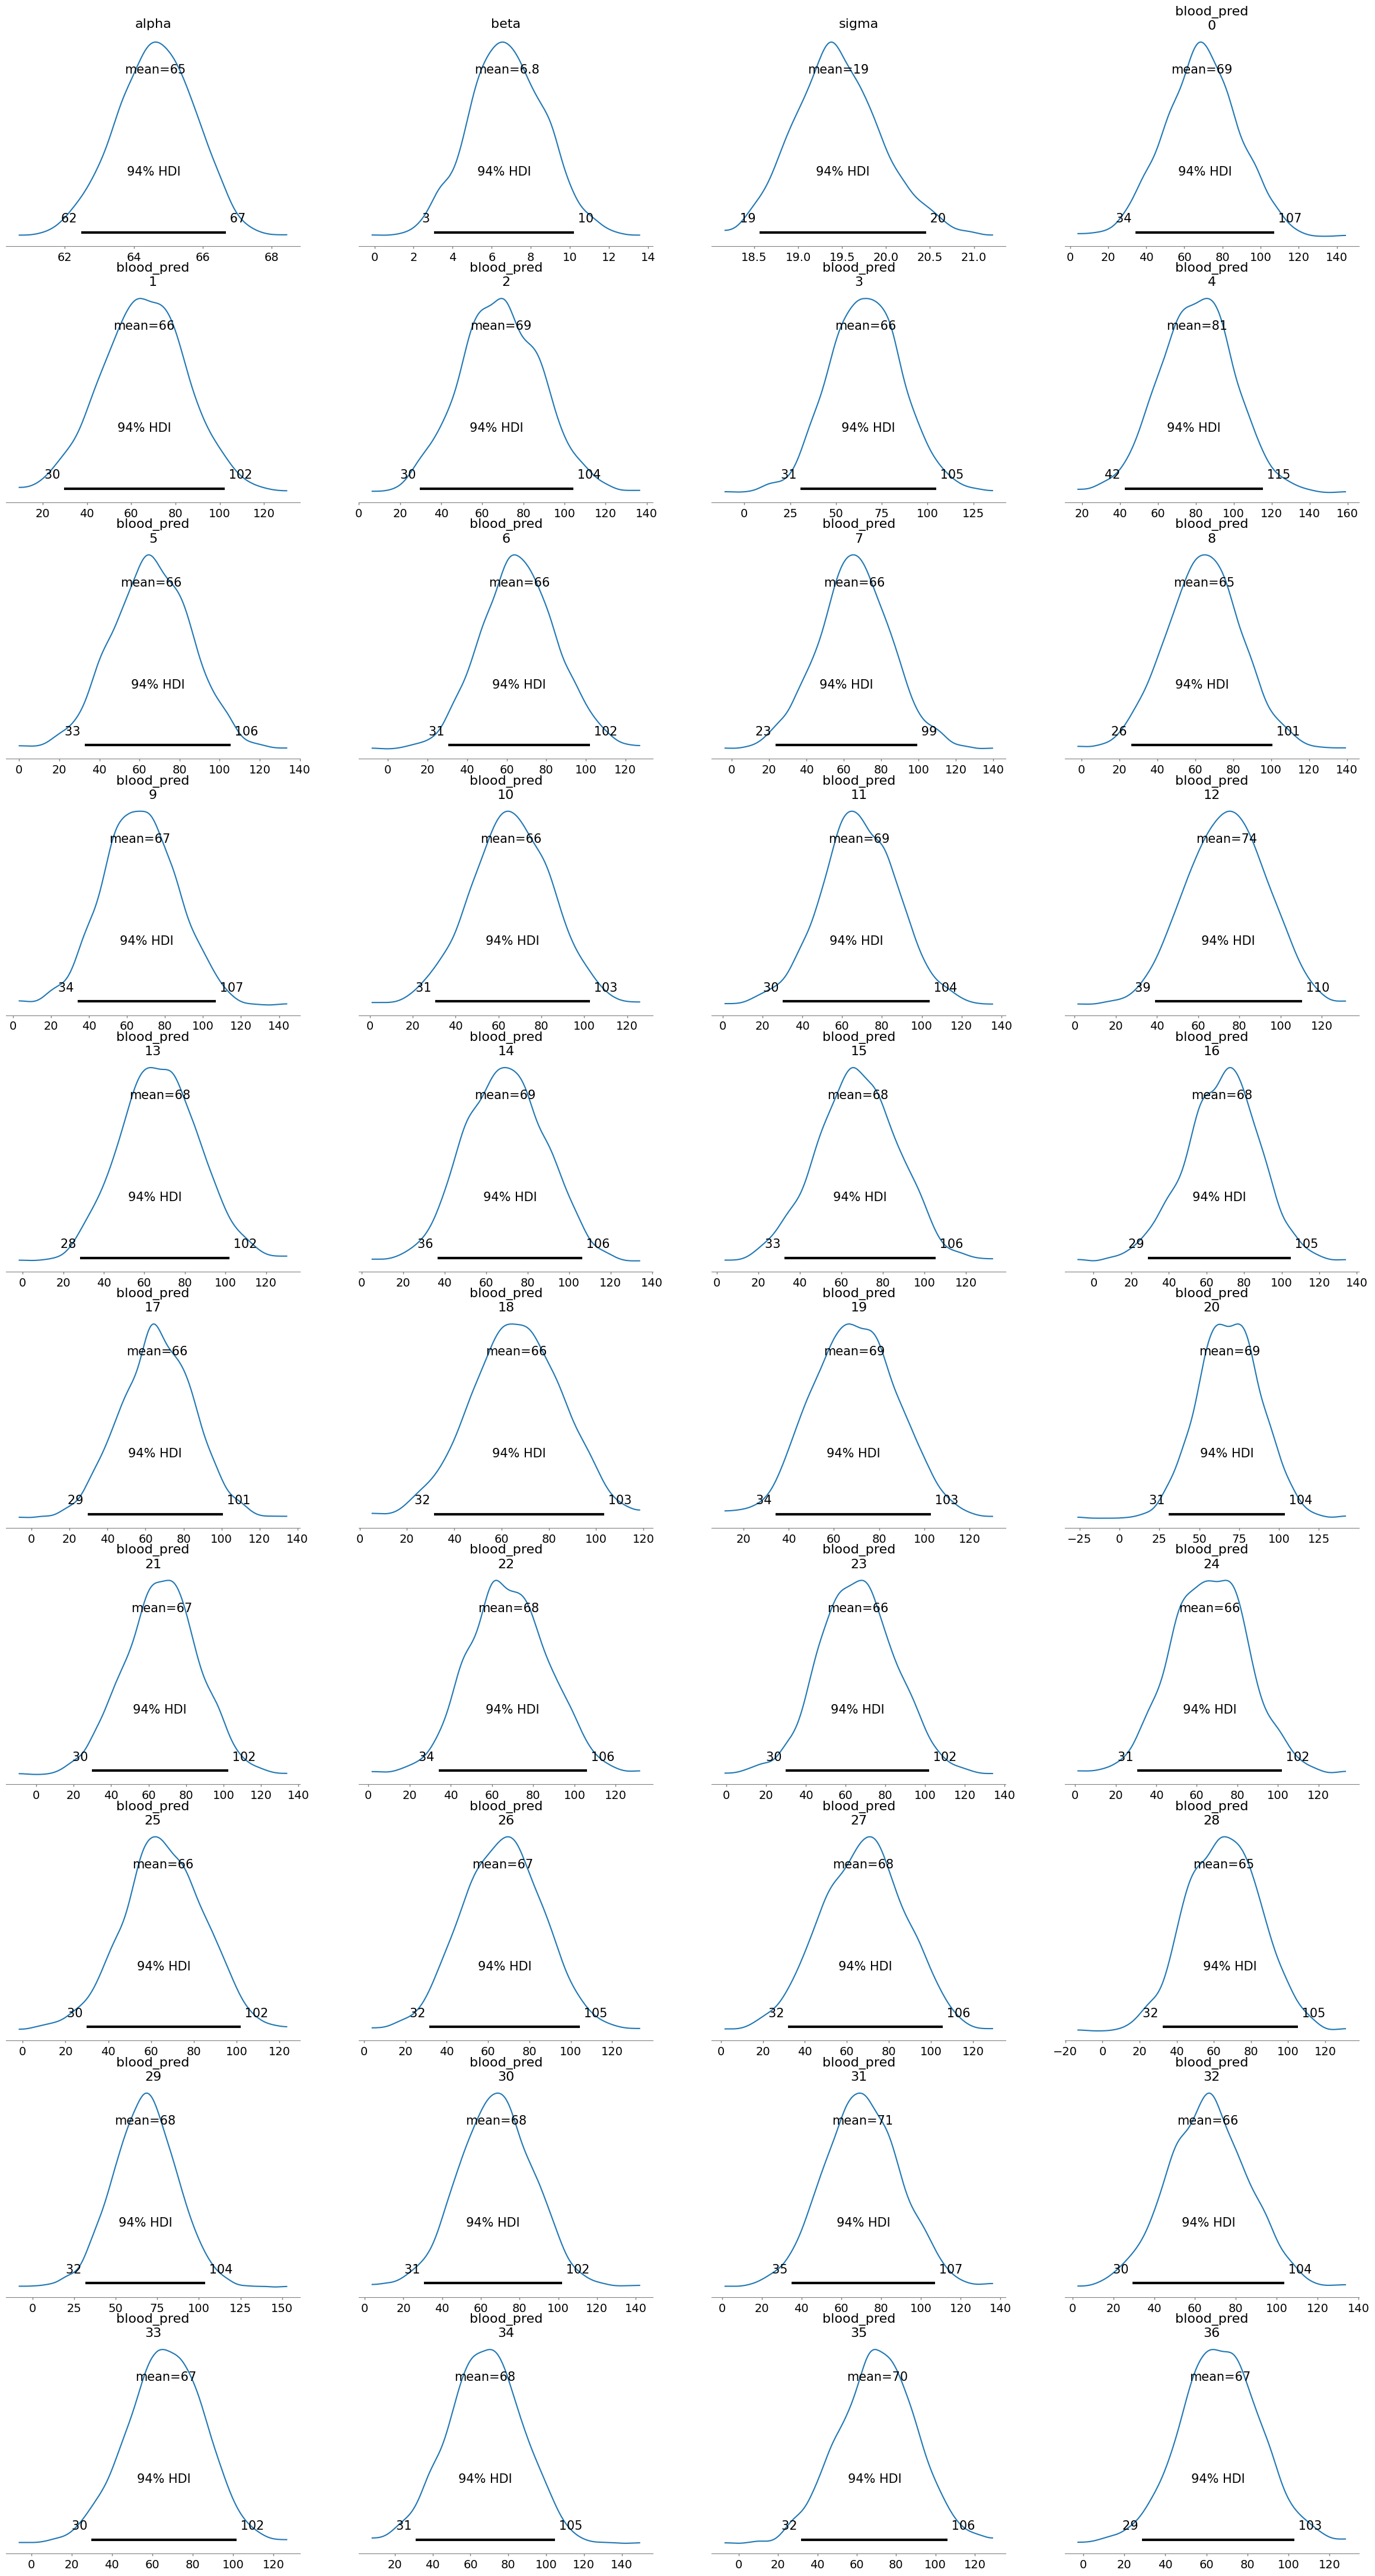

In [166]:
az.plot_posterior(fit)

## 0. delete cache of model

In [103]:
# import the relevant modules
import shutil
import httpstan.models
import httpstan.cache

In [104]:
httpstan.cache.list_model_names()

['models/ocsocddq',
 'models/7jkuhphp',
 'models/airfqefx',
 'models/vdtk4ema',
 'models/6juikuum']

In [110]:
httpstan.cache.delete_model_directory('models/6juikuum') ## add the model pointer you want to remove

## 0. Saving model (not done)

In [24]:

def save(obj, filename):
    """Save compiled models for reuse."""
    import pickle
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def load(filename):
    """Reload compiled models for reuse."""
    import pickle
    return pickle.load(open(filename, 'rb'))

In [25]:
# save(model, 'norm_model.pic')
# new_model = load('norm_model.pic')


In [188]:
import pickle

In [26]:
# with open("model_fit.pkl", "rb") as f:
#     data_dict = pickle.load(f)
#     # or with a list
#     # data_list = pickle.load(f)
# fit_new = data_dict['fit']
# # fit = data_list[1]

In [ ]:
# with open("model_fit.pkl", "wb") as f:
#     pickle.dump({'model' : stan_model, 'fit' : fit}, f, protocol=-1)
#     # or with a list
#     # pickle.dump([model, fit], f, protocol=-1)